## Solving Euler Equations with K-T Scheme

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from kurganov_tadmor import *

### Equation

We solve the Euler equations in 1D 

$$
\begin{equation} 
\partial_t 
\begin{bmatrix} \rho \\ \rho v \\ E \end{bmatrix} 
+ 
\partial_x 
\begin{bmatrix} \rho v \\ \rho v^2 +p \\ v (E+p) \end{bmatrix} 
= 0 
\end{equation}
$$

with the equation of state
$$
\begin{equation}
p = (\gamma-1) \left(E-\frac{1}{2} \rho v^2\right), \qquad \gamma=1.4
\end{equation}
$$

on the domain $(x,t)\in([0,1]\times[0,0.1])$ with initial data for a *Sod shock tube*:

$$
\begin{equation}
(\rho, v, p)_{t=0} = 
\begin{cases}
(1,0,1) & \text{if} & 0<x\leq0.5 \\
(0.125, 0, 0.1) & \text{if} & 0.5<x<1
\end{cases}
\end{equation}
$$
and Dirichlet boundary data set by initial data on each boundary. The solution is computed using 400 cells and CFL number is taken to be 0.75.

In [2]:
pars = Pars1d(x_init=0.0, x_final=1.0, t_final=0.3, dt_out=0.005, J=400, cfl=0.75, scheme="sd2")
pars.gamma = 1.4

In [3]:
# Euler equation
class Euler1d(Equation1d):
    def initial_data(self):
        u = np.zeros((self.J + 4, 3))
        midpoint = int(self.J / 2) + 2

        left_v = [1, 0, 1.0 / (self.gamma - 1.0)]
        right_v = [0.125, 0.0, 0.1 / (self.gamma - 1.0)]

        # Left side
        u[:midpoint, :] = left_v
        # Right side
        u[midpoint:, :] = right_v

        return u

    def boundary_conditions(self, u):
        left_v = [1, 0, 1.0 / (self.gamma - 1.0)]
        right_v = [0.125, 0.0, 0.1 / (self.gamma - 1.0)]
        # Left side
        u[0] = left_v
        u[1] = left_v
        # Right side
        u[-1] = right_v
        u[-2] = right_v

    def flux_x(self, u):
        f = np.zeros_like(u)
        rho = u[:, 0]
        u_x = u[:, 1] / rho
        E = u[:, 2]
        p = (self.gamma - 1.0) * (E - 0.5 * rho * u_x ** 2)

        f[:, 0] = rho * u_x
        f[:, 1] = rho * u_x ** 2 + p
        f[:, 2] = u_x * (E + p)

        return f

    def spectral_radius_x(self, u):
        rho = u[:, 0]
        u_x = u[:, 1] / rho
        p = (self.gamma - 1.0) * (u[:, 2] - 0.5 * rho * u_x ** 2)
        return np.abs(u_x) + np.sqrt(self.gamma * p / rho)

### Solution

In [4]:
eqn = Euler1d(pars)
soln = Solver1d(eqn)
soln.solve()

### Animation

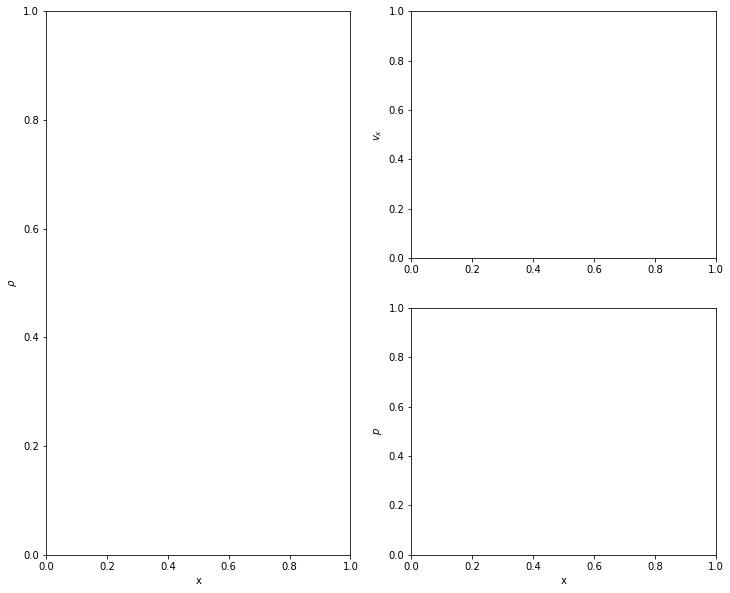

In [7]:
fig = plt.figure(figsize=(12,10))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,4)

ax1.set_xlabel('x')
ax1.set_ylabel(r'$\rho$')
ax2.set_ylabel(r'$v_x$')
ax3.set_xlabel('x')
ax3.set_ylabel(r'$p$')
plt.show()

line_u=[]
for ax in [ax1, ax2, ax3]:
  ax.set_xlim(0, 1.05)
  ax.set_ylim(0.1, 1.05)
  line_u.append(ax.plot([], [], linewidth=1, color='b', marker='o', markersize=2)[0])

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

j0 = slice(2,-2)
def animate(i):
    rho=soln.u_n[i,j0,0]
    u_x = soln.u_n[i,j0,1]/soln.u_n[i,j0,0]
    p = (soln.gamma-1.)*(soln.u_n[i,j0,2]-0.5*rho*u_x**2)
    line_u[0].set_data(soln.x[j0], rho)
    line_u[1].set_data(soln.x[j0], u_x)
    line_u[2].set_data(soln.x[j0], p)

plt.close()
anim = animation.FuncAnimation(fig, animate, frames=soln.Nt, interval=100, blit=False);
anim.save('results/euler.mp4')